# Анализ сервиса аренды самокатов GoFast

Заказчик - сервис аренды самокатов GoFast. Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках.

**Цель исследования:**

Существует теория, что данных присутствуют определенные закономерности, которые могут влиять на работу сервиса в целом.


**Ход исследования**

Данные получим из файлов:

/datasets/users_go.csv - пользователи     
/datasets/rides_go.csv - поездки     
/datasets/subscriptions_go.csv - подписки

На первом этапе требуется оценить их качество, поэтому проведем обзор данных. Затем исправим возможные ошибки, а после перейдем к поиску закономерностей, необходимых для решения поставленной задачи.

**Оглавление**

1. [Описание данных](#1) 
2. [Загрузка данных](#2) 
3. [Предобработка данных](#3)
4. [Исследовательский анализ данных](#4)
    1. [Частота встречаемости городов](#5) 
    1. [Соотношение пользователей с подпиской и без подписки](#6)
    1. [Возраст пользователей](#7)
    1. [Расстояние, которое пользователь преодолел за одну поездку](#8)
    1. [Продолжительность поездок](#9)
    
1. [Объединение данных](#10)
1. [Подсчёт выручки](#12)
1. [Проверка гипотез](#13)
    1. [Гипотеза 1](#14)
    1. [Гипотеза 2](#15)
    1. [Гипотеза 3](#16)
    
1. [Выводы](#18)

<a id="1"></a>
## Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.
#### Пользователи — /datasets/users_go.csv
- user_id	уникальный идентификатор пользователя
- name	имя пользователя
- age	возраст
- city	город
- subscription_type	тип подписки (free, ultra)

#### Поездки — /datasets/rides_go.csv
- user_id	уникальный идентификатор пользователя
- distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date	дата совершения поездки

#### Подписки — /datasets/subscriptions_go.csv
- subscription_type	тип подписки
- minute_price	стоимость одной минуты поездки по данной подписке
- start_ride_price	стоимость начала поездки
- subscription_fee	стоимость ежемесячного платежа

In [42]:
pip install cufflinks plotly

Note: you may need to restart the kernel to use updated packages.


In [43]:
#импортируем библиотеки
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go 
import seaborn as sns
from scipy import stats as st
pd.set_option('display.float_format', '{:,.2f}'.format)

<a id="2"></a>
## Загрузка данных

In [44]:
#прочитаем файл о пользователях
data_user = pd.read_csv('/datasets/users_go.csv')
data_user.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [45]:
data_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [46]:
#посчитаем пропуски
data_user.isna().sum().sort_values()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

В таблице о пользователях нет пропусков, типы данных выглядят корректно.

In [47]:
#прочитаем файл о поездках
data_go = pd.read_csv('/datasets/rides_go.csv')
data_go.head()

,user_id,distance,duration,date
0,1,"4,409.92",25.60,2021-01-01
1,1,"2,617.59",15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,"2,694.78",18.51,2021-08-11
4,1,"4,028.69",26.27,2021-08-28


In [48]:
data_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [49]:
#посчитаем пропуски
data_go.isna().sum().sort_values()

user_id     0
distance    0
duration    0
date        0
dtype: int64

В файле о поездках нет пропусков, но требуется преобразовать тип данных в колонке с датой.

In [50]:
#прочитаем файл о поездках
data_sub = pd.read_csv('/datasets/subscriptions_go.csv')
data_sub.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [51]:
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В последнем файле в двух строках хранится информация о стоимости по каждому тарифу проката самокатов.

Подытог: в данных нет пропусков, следует изменить тип колонки с датой.

<a id="3"></a>
### Предобработка данных

In [52]:
#приведем столбец даты к нужному формату
data_go['date'] = pd.to_datetime(data_go['date'])
#создадим новый столбец с номером месяца
data_go['month'] = data_go['date'].dt.month
data_go.head()

,user_id,distance,duration,date,month
0,1,"4,409.92",25.60,2021-01-01,1
1,1,"2,617.59",15.82,2021-01-18,1
2,1,754.16,6.23,2021-04-20,4
3,1,"2,694.78",18.51,2021-08-11,8
4,1,"4,028.69",26.27,2021-08-28,8


In [53]:
#проверим датафреймы на явные дубликаты
print(data_user.duplicated().sum())
data_go.duplicated().sum()

31


0

В файле с пользователями присутсвуют явные дубли, удалим поторения, оставив первые записи, чтобы не исключить пользователей полностью.

In [54]:
data_user.drop_duplicates(keep='first', inplace=True)
data_user.duplicated().sum()

0

Подытог: в колонке с пользователями мы удалили повторяющиеся значения профилей. Таким образом избавились от явных дубликатов. Также создали новую колонку с номером месяца поездки на самокате.

In [55]:
#проверим период данных
data_go['date'].describe(datetime_is_numeric=True)

count                            18068
mean     2021-06-30 19:47:21.266327296
min                2021-01-01 00:00:00
25%                2021-04-02 00:00:00
50%                2021-06-30 00:00:00
75%                2021-09-28 00:00:00
max                2021-12-30 00:00:00
Name: date, dtype: object

In [56]:
#округлим значения дистанции и времени поездок на самокатах
data_go['duration'] = round(data_go['duration'], 0).astype('int64')
data_go['distance'] = round(data_go['distance'], 0).astype('int64')
data_go.head()

,user_id,distance,duration,date,month
0,1,4410,26,2021-01-01,1
1,1,2618,16,2021-01-18,1
2,1,754,6,2021-04-20,4
3,1,2695,19,2021-08-11,8
4,1,4029,26,2021-08-28,8


В нашей выгрузке данные за один гор с 1 января 2021 по 30 декабря 2021 года, что не вызовет проблемы при агрегации по месяцам.

<a id="4"></a>
## Исследовательский анализ данных

<a id="5"></a>
#### Частота встречаемости городов

In [57]:
user_city = data_user.groupby('city').count().sort_values(by='name', ascending=False)
user_city['proc'] = (user_city['name'] / user_city['name'].sum()) * 100
user_city

,user_id,name,age,subscription_type,proc
city,,,,,
Пятигорск,219,219,219,219,14.28
Екатеринбург,204,204,204,204,13.30
Ростов-на-Дону,198,198,198,198,12.91
Краснодар,193,193,193,193,12.58
Сочи,189,189,189,189,12.32
Омск,183,183,183,183,11.93
Тюмень,180,180,180,180,11.73
Москва,168,168,168,168,10.95


In [58]:
#построим визуализацию распределения количества пользователей по городам
fig = px.histogram(user_city, # загружаем данные
                   x=user_city.index,
                   y='name',
                   color=user_city.index, # указываем столбец с данными для оси X
                   title='Распределение количества городов',
                   barmode='overlay') # выбираем «полупрозрачный» тип отображения столбцов
fig.update_xaxes(title_text='Город') # подпись для оси X
fig.update_yaxes(title_text='Количество пользователей') # подпись для оси Y
fig.show() # выводим график

Больше всего пользователей зарегистрировано в г. Пятигорск, Екатеринбург и Ростов-на-Дону. Среди жителей Москвы сервис имеет невысокую популярность, что требует более детального внимания.

<a id="6"></a>
#### Соотношение пользователей с подпиской и без подписки

In [59]:
#соотношение пользователей с подпиской и без
data_type = data_user.groupby('subscription_type').count().sort_values(by='name', ascending=False)
data_type

,user_id,name,age,city
subscription_type,,,,
free,835,835,835,835
ultra,699,699,699,699


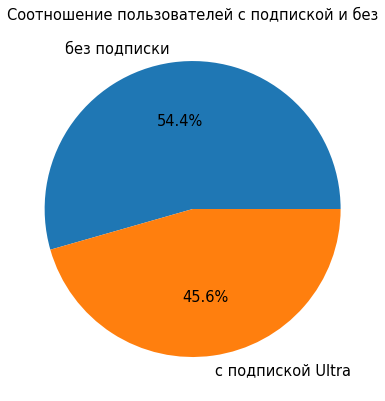

In [60]:
#построим визуализацию
labels = ['без подписки', 'с подпиской Ultra']
sizes = data_type['name']

fig, ax = plt.subplots(figsize=(10, 7), dpi=70)
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
       textprops={'fontsize': 15})
ax.set_title('Соотношение пользователей с подпиской и без', fontsize=15)
ax.tick_params()
plt.show()  

Количество пользователей самокатов без подписки преобладает над количеством тех, кто уже оформил подписку Ultra.

<a id="7"></a>
#### Возраст пользователей

In [61]:
#соотношение пользователей по возрасту
data_age = data_user.groupby('age').count().sort_values(by='name', ascending=False)
data_age['proc'] = (data_age['name'] / data_age['name'].sum()) * 100
data_age.head(10)

,user_id,name,city,subscription_type,proc
age,,,,,
25,145,145,145,145,9.45
24,132,132,132,132,8.60
26,131,131,131,131,8.54
23,129,129,129,129,8.41
27,119,119,119,119,7.76
22,119,119,119,119,7.76
28,112,112,112,112,7.30
21,93,93,93,93,6.06
20,71,71,71,71,4.63


In [62]:
data_user['age'].describe()

count   1,534.00
mean       24.90
std         4.57
min        12.00
25%        22.00
50%        25.00
75%        28.00
max        43.00
Name: age, dtype: float64

In [63]:
#визуализируем данные
fig = px.bar(data_age, x=data_age.index, y='name',
             title='Количество пользователей по возрасту',
             labels={'name':'Количество пользователей', 'age':'Возраст'}, height=400)
fig.show()

В приложении регистрируются пользователи от 12 до 43 лет. В этом диапазоне больше всех зарегистрированных в возрасте 25 лет (почти 10% от всех пользователей) с нормальным распределением остальных возрастов вокруг этого значения.

<a id="8"></a>
#### Расстояние, которое пользователь преодолел за одну поездку

In [64]:
data_go['distance'].describe()

count   18,068.00
mean     3,070.66
std      1,116.83
min          1.00
25%      2,543.00
50%      3,134.00
75%      3,776.00
max      7,211.00
Name: distance, dtype: float64

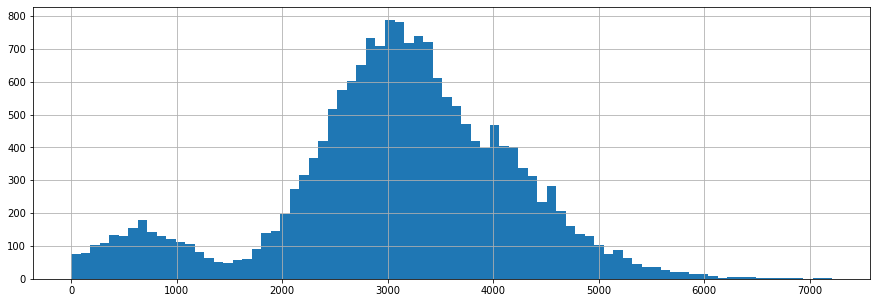

In [65]:
#визуализируем данные
data_go['distance'].hist(bins=80, figsize=(15, 5))
plt.show()

Чаще всего дальность поездок - это около 3000 метров (среднее 3070, а медиана 3133). Распредление выглядит нормально, за исключением дополнительного всплеска в районе 600 метров, что требует более детального изучения.

<a id="9"></a>
#### Продолжительность поездок

In [66]:
data_go['duration'].describe()

count   18,068.00
mean        17.80
std          6.10
min          0.00
25%         14.00
50%         18.00
75%         22.00
max         41.00
Name: duration, dtype: float64

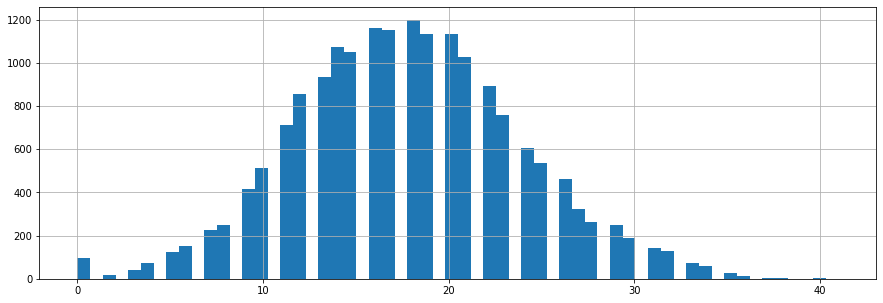

In [67]:
#визуализируем данные
data_go['duration'].hist(bins=60, figsize=(15, 5))
plt.show()

Средняя прододжительность одной поездки около 18 минут. Также был выявлен нестандартный вплеск значений в районе 1 секунды, что также требует детального анализа.

Подытог: приложение популярно больше всего у жителей Пятигорска, в то время как Москва по количеству пользователей представлена на последнем месте, что не типично с учетом численности этого города. Стоит обратить внимание еще и на то, что больше половины пользователей не имеют подписки. Это требует пристального внимания маркетинга. 

Средний возраст пользователя самокатом - 25 лет. Дальность поездки - обычно 3 км. Имеется нетипичный всплеск данных в поездках в районе 600 метров. Длительность поездки в среднем - 18 минут. Здесь также заметен нетипичный всплекс поездок длительностью 1 секунда, что может быть связано с особенностями работы тарификации или приложения.

<a id="10"></a>
## Объединение данных

<a id="11"></a>
#### Создадим объединенный датафрейм

In [68]:
data = data_user.merge(data_go, how='inner', on='user_id') \
              .merge(data_sub, how='inner', on='subscription_type')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029,26,2021-08-28,8,6,0,199


In [69]:
#проверим данные после объединения, так как размерность таблиц разная, будем отталкиваться от самой большой таблицы data_go
print("Количество строк data_go:", data_go['user_id'].count())
print("Количество строк ПОСЛЕ объединения:", data['user_id'].count())
#проверим количество пользователей в первоначальном файле и ПОСЛЕ объединенном
print("Количество пользователей ДО объединения:", len(data_user['user_id'].unique()))
print("Количество пользователей ПОСЛЕ объединения:", len(data['user_id'].unique()))

Количество строк data_go: 18068
Количество строк ПОСЛЕ объединения: 18068
Количество пользователей ДО объединения: 1534
Количество пользователей ПОСЛЕ объединения: 1534


In [70]:
#проверим датафрейм на дубликаты и пропуски
print('Количество явных дубликатов', data.duplicated().sum())
print()
print('Количество пропусков', data.isna().sum().sort_values())

Количество явных дубликатов 0

Количество пропусков user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


<a id="11"></a>
#### Создадим ещё два датафрейма:

c данными о пользователях без подписки;     
с данными о пользователях с подпиской.

In [71]:
data_free = data.loc[data['subscription_type'] == 'free']
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2516,15,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,847,16,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004,20,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1206,10,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047,17,2021-02-14,2,8,50,0


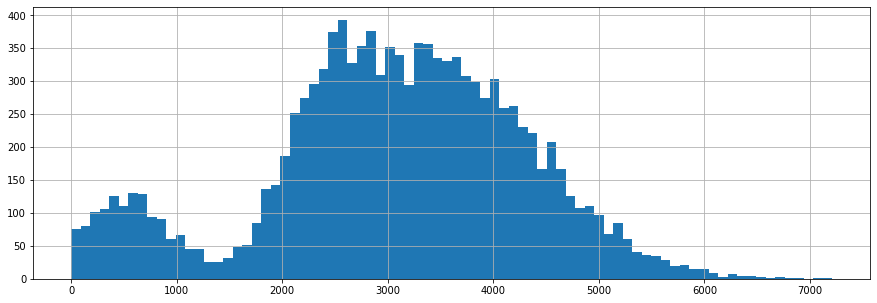

In [72]:
#визуализируем данные о дальности поездок для пользователей без подписки
data_free['distance'].hist(bins=80, figsize=(15, 5))
plt.show()

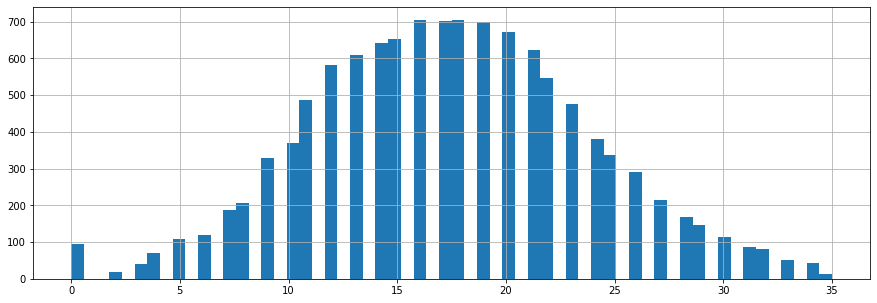

In [73]:
#визуализируем данные о длительности поездок для пользователей без подписки
data_free['duration'].hist(bins=60, figsize=(15, 5))
plt.show()

In [74]:
data_ultra = data.loc[data['subscription_type'] == 'ultra']
data_ultra.head(22)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029,26,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2771,17,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039,15,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842,23,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3413,15,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,749,15,2021-11-22,11,6,0,199


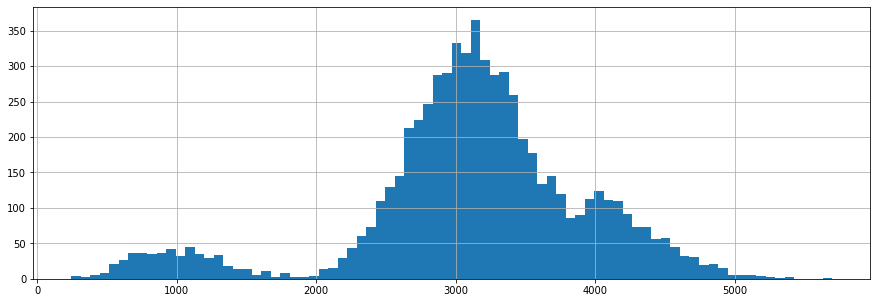

In [75]:
#визуализируем данные о дальности поездок для пользователей с подпиской
data_ultra['distance'].hist(bins=80, figsize=(15, 5))
plt.show()

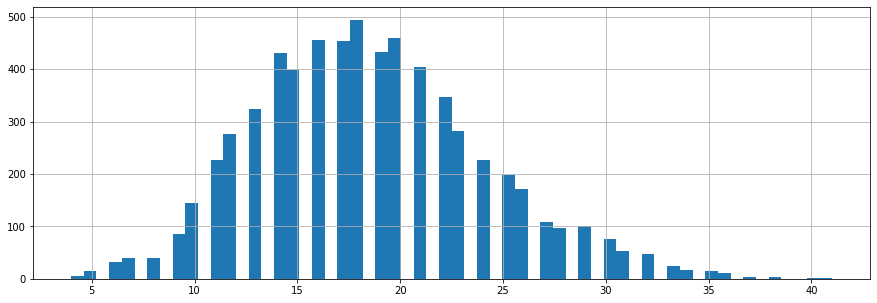

In [76]:
#визуализируем данные о времени поездок для пользователей с подпиской
data_ultra['duration'].hist(bins=60, figsize=(15, 5))
plt.show()

Анализируя обе гистограммы можно отметить раличия в длительности поездок у пользователей с подпиской и без. Пик в районе 600 метров, который мы отметили выше, приходится на пользователей без подписки. Это же касается и пика с длительностью поездки в 1 минуту. В то время как подписчики тарифа Ultra предпочитают более длительные поездки и по времени они имеют нормальное распределение. Скорее всего это связано с тарификацией или сложностями авторизации в приложении для пользователей без подписки, что может являться еще одним барьером, из-за которого пользователи не оформляют подписку.

Подытог: для дальнейших расчетов мы создали объединенный датафрейм и два дополнительных, где разделили пользователей с подбиской и без. Возможно, наблюдаются проблемы с аторизацией у пользователей без подписки, т.к. есть пик в поездках в 1 минуту. Также же мы заметили, что поездки без подписки ограничиваются более короткими дистанциями.

<a id="12"></a>
## Подсчёт выручки

In [77]:
#найдем общее расстояние, время и количество поездок по каждому пользователю
data_total = pd.pivot_table(data, index=['month', 'user_id'], \
                           values = ['distance', 'duration', 'name', 'subscription_type'], \
                           aggfunc = {'distance': sum, 
                                      'duration' : sum,
                                      'user_id': 'count',
                                      'subscription_type': min})
data_total

distance  duration subscription_type  user_id
month user_id                                               
1     1            7028        42             ultra        2
      3            3062        13             ultra        1
      5            3915        12             ultra        1
      7            6478        28             ultra        2
      12           3577        32             ultra        1
...                 ...       ...               ...      ...
12    1525         4598        33              free        1
      1526         3644        23              free        1
      1528         3999        10              free        1
      1532         6112        40              free        2
      1534         2372        16              free        1

[11331 rows x 4 columns]

In [78]:
#создадим функцию для подсчета выручки
def revenue(row):
    if row['subscription_type'] == 'ultra':
        return 6 * row['duration'] + 199
    elif row['subscription_type'] == 'free':
        return 8 * row['duration'] + 50 * row['user_id']
    else:
        return 0
    
#создадим новый столбец с выручкой
data_total['revenue'] = data_total.apply(revenue, axis=1)
data_total.head(10)

distance  duration subscription_type  user_id  revenue
month user_id                                                        
1     1            7028        42             ultra        2      451
      3            3062        13             ultra        1      277
      5            3915        12             ultra        1      271
      7            6478        28             ultra        2      367
      12           3577        32             ultra        1      391
      13           6688        42             ultra        2      451
      14           7700        34             ultra        2      403
      15           4188        38             ultra        1      427
      20           3517        28             ultra        1      367
      22           3059        12             ultra        1      271

In [79]:
#найдем общую сумму выручки
data_total['revenue'].sum()

3812767

Суммарный годовой доход компании проката самокатов составил 3853677.0 руб.

<a id="13"></a>
## Проверка гипотез

<a id="14"></a>
#### Гипотеза 1. Тратят ли пользователи с подпиской больше времени на поездки?

Нулевая гипотеза - среднее время поездок всех пользователей одинаково.    
Альтернативная - среднее время поездок пользователей с подпиской больше.
Таким образом 

$ \mathsf{H}_0: \mu_1 = \mu_2 $<br>
$ \mathsf{H}_1: \mu_1 > \mu_2 $,

где $ \mu_1 $ и $\mu_2$ это математическое ожидание времени поездки пользователей с подпиской и без соответственно.   
$ alpha = 0.05 $

Для двух независимых выборок используем двусторонний т-тест с параметром при разной дисперсией.

In [80]:
alpha = 0.05
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], equal_var=False, alternative='greater')
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.1540423907706558e-37
Отвергаем нулевую гипотезу


Это означает, что длительность поездок пользователей с подпиской больше, чем без, при уровне значимости в 0.05 %

<a id="15"></a>
#### Гипотеза 2. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.    
Нулевая гипотеза - среднее расстояние поездок пользователей с подпиской равно оптимальному расстоянию.
Альтернативная - среднее расстояние поездок пользователей с подпиской больше оптимального в 3130 метров.

$ \mathsf{H}_0: \mu_1 = 3100 $<br>
$ \mathsf{H}_1: \mu_1 > 3100 $,

где $ \mu_1 $ это математическое ожидание расстояния поездок пользователей с подпиской.   
$ alpha = 0.05 $

Проверим гипотезу.

In [81]:
distance = 3130
alpha = 0.05

results = st.ttest_1samp(data_ultra['distance'], distance, alternative='greater')

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.9195649894697724
Не получилось отвергнуть нулевую гипотезу


Так как при уровне значимости в 0.05% нулевую гипотезу не удалось отвергнуть, то можно предполагать, что дальность поездок пользователей с подпиской является оптимальной с точки зрения износа самокатов.

<a id="16"></a>
#### Гипотеза 3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Нулевая гипотеза - помесячные выручки пользователей с подпиской и без одинаковы.
Альтернативная - помесячная выручка пользователей с подпиской выше.

$ \mathsf{H}_0: \mu_1 = \mu_2 $<br>
$ \mathsf{H}_1: \mu_1 > \mu_2 $,

где $ \mu_1 $ и $\mu_2$ это математическое ожидание помесячной выручки пользователей с подпиской и без соответственно.   
$ alpha = 0.05 $

Проверим гипотезу.

In [82]:
ultra_rev = data_total.loc[data_total.subscription_type == 'ultra', 'revenue'] 
free_rev = data_total.loc[data_total.subscription_type == 'free', 'revenue'] 
alpha = 0.05

results = st.ttest_ind(ultra_rev, free_rev, equal_var=False, alternative='greater')


print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.6046721201208006e-47
Отвергаем нулевую гипотезу


Это означает, что при статистической значимости в 0.05% помесячный доход от пользователей с подпиской выше.

<a id="17"></a>
#### Гипотеза 4. Снизилось ли количество обращений в техподдержку после обновления сервера?

Условия: Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Так как оба файла сожержать данные одних и тех же пользователей ДО и ПОСЛЕ, то мы имеем дело с двумя зависимыми выборками. Нам потребуется оценить среднее количество обращений ДО и ПОСЛЕ.

Здесь нам необходимо использовать односторонний тест, потому что нас интересует только одно направление изменения (уменьшилось ли количество обращений или нет). Нам не интересно, увеличилось ли количество обращений после обновления, так как это не соответствует нашей изначальной гипотезе о положительном эффекте обновления серверов.

Основная (нулевая) гипотеза в этом случае может утверждать, что различия между количеством обращений до и после обновления отсутствуют или что количество обращений после обновления больше или равно, чем до.

Альтернативная гипотеза будет утверждать, что количество обращений после обновления меньше, чем до обновления.

<a id="18"></a>
## Выводы

Заказчик - сервис аренды самокатов GoFast. Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Мы проверяли теорию о том, что в данных присутствуют определенные закономерности, которые могут влиять на работу сервиса в целом.

Первоначально мы проверили сами данные. В данных нет пропусков, мы изменили только тип колонки с датой.

В колонке с пользователями мы удалили повторяющиеся значения профилей. Таким образом избавились от явных дубликатов. Также создали новую колонку с номером месяца поездки на самокате.

Затем мы составили профиль пользователя. Приложение популярно больше всего у жителей Пятигорска, в то время как Москва по количеству пользователей представлена на последнем месте, что не типично с учетом численности этого города. Стоит обратить внимание еще и на то, что больше половины пользователей не имеют подписки. Это требует пристального внимания со стороны маркетинга, учитывая заявление о популярности сервиса.

Средний возраст пользователя самокатом - 25 лет. Дальность поездки - обычно в районе 3 км. Имеется нетипичный всплеск данных в поездках в районе 600 метров. Длительность поездки в среднем - 18 минут. Здесь также заметен нетипичный всплекс поездок длительностью 1 секунда, что может быть связано с особенностями работы тарификации или приложения.

Для дальнейших расчетов мы создали объединенный датафрейм и два дополнительных, где разделили пользователей с подбиской и без. Возможно, наблюдаются проблемы с аторизацией у пользователей без подписки, т.к. есть пик в поездках в 1 минуту. Также же мы заметили, что поездки пользователей без подписки ограничиваются более короткими дистанциями.

Был подсчитан суммарный годовой доход компании, он составил 3853677.0 руб.

**Мы проверили следующие гипотезы:**

1) Тратят ли пользователи с подпиской больше времени на поездки?

Длительность поездок пользователей с подпиской больше, чем без, при уровне значимости в 0.05 %

2) Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Можно предполагать, что при уровне значимости в 0.05% дальность поездок пользователей с подпиской является оптимальной с точки зрения износа самокатов.

3) Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

При статистической значимости в 0.05% помесячный доход от пользователей с подпиской выше.

**Рекомендации: увеличить количество пользователей с подпиской, расширить географию пользователей, связаться с отделом маркетинга по поводу продвижения приложения и с отделом разработчиков для выяснения прирды нетипичных всплесков в данных.**